#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

In [1]:
# Data Imports
import numpy as np
import pandas as pd

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb

# For evaluating our ML results
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Making the Confusion Matrix
def confusion_matrix_c(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = ["Negative", "Positive"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
def plot_roc_auc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Data

In [3]:
data = pd.read_csv('banking.csv', header=0)
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


### Data exploration

In [5]:
data.isnull().any().sum()

0

In [6]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

Group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic"

In [7]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [8]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [9]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

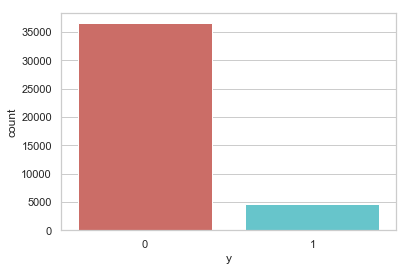

In [10]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [11]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])

pct_of_no_sub = count_no_sub/(len(data['y']))
print("percentage of no subscription is", pct_of_no_sub*100)

pct_of_sub = count_sub/(len(data['y']))
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


Classes are imbalanced, ratio of no-subscription to subscription instances is 89:11.

In [12]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [13]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [14]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [15]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


Visualizations

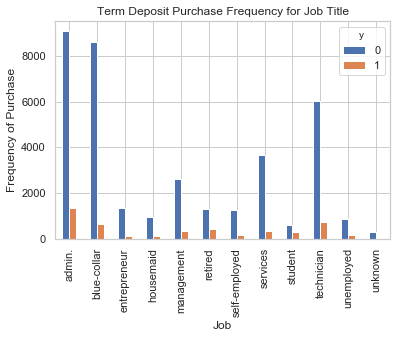

In [16]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Term Deposit Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase');

Job Title a good predictor of the outcome variable

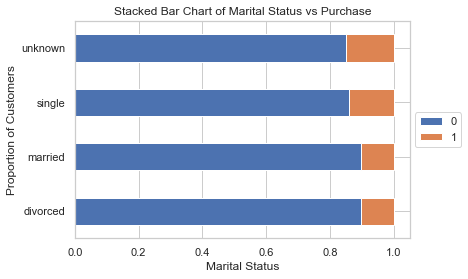

In [17]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype('float32'), axis=0).plot(kind='barh', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers');

Marital Status looks a bad predictor for the outcome variable

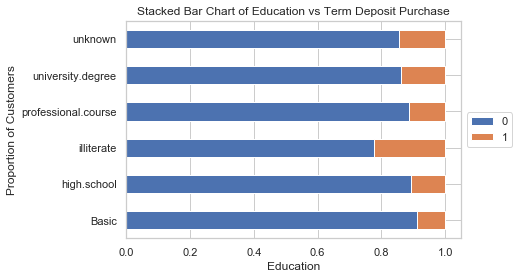

In [18]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype('float32'), axis=0).plot(kind='barh', stacked=True)
plt.title('Stacked Bar Chart of Education vs Term Deposit Purchase')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Education')
plt.ylabel('Proportion of Customers');

Education seems a good predictor of the outcome variable.

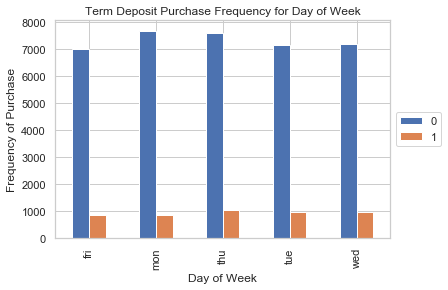

In [19]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Term Deposit Purchase Frequency for Day of Week')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase');

Day of the week looks a bad predictor of outcome variable

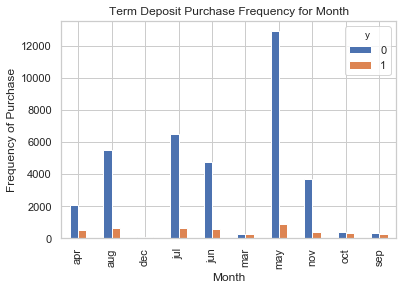

In [20]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Term Deposit Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase');

Month might be a good predictor of the outcome variable.

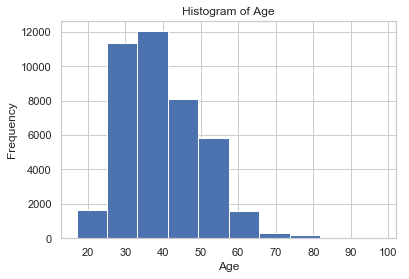

In [21]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');

Most customers of the bank are in the age range of 30-40.

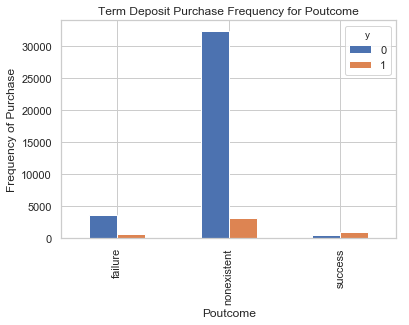

In [22]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Term Deposit Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase');

Poutcome seems to be a good predictor of the outcome variable.

### One Hot Encoding(Dummy Variables)

In [23]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

### Over-sampling using SMOTE

In [24]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

In [25]:
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  51234
Number of no subscription in oversampled data 25617
Number of subscription 25617
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Recursive feature elimination

In [26]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [27]:
logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values)
print(rfe.support_)
print(rfe.ranking_)
temp = pd.Series(rfe.support_,index = X)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False  True False False False  True False False False
 False False False False False False  True False False False False False
 False False False False False False False False  True  True False False
  True False  True False False  True  True  True  True False  True  True
  True  True  True False  True False  True False False False  True False
  True]
[38 36 24 39  1 11 14 34  1 32 31 21 15 23 26 10 20 17  1 41 40 19 27 37
 18  9  3  4 22  5  7  6  1  1 42 33  1 25  1 13  2  1  1  1  1  8  1  1
  1  1  1 29  1 30  1 28 35 16  1 12  1]
Index(['previous', 'euribor3m', 'job_student', 'default_no', 'default_unknown',
       'housing_unknown', 'loan_no', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_sep', 'day_of_week_mon',
       'poutcome_failure', 'poutcome_success'],
      dtype='object')


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [28]:
cols=selected_features_rfe
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [29]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.542763
         Iterations: 35
                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.217     
Dependent Variable:     y                  AIC:                55655.8604
Date:                   2019-03-17 20:26   BIC:                55832.7436
No. Observations:       51234              Log-Likelihood:     -27808.   
Df Model:               19                 LL-Null:            -35513.   
Df Residuals:           51214              LLR p-value:        0.0000    
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
                   Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------
previous            0.2753    0.0512   5.3738 0.0000     0.1749    0.3757
eu

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The p-values for four variables are very high, therefore, we will remove them.

In [30]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [31]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.552987
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.202     
Dependent Variable:   y                 AIC:               56695.4816
Date:                 2019-03-17 20:26  BIC:               56836.9881
No. Observations:     51234             Log-Likelihood:    -28332.   
Df Model:             15                LL-Null:           -35513.   
Df Residuals:         51218             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.4714   0.0074 -63.7225 0.0000 -0.4859 -0.4569
job_blue-collar 

### Logistic Regression Model Fitting

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
y_pred_lr = lr.predict(X_test)

In [34]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      7706
           1       0.78      0.66      0.72      7665

   micro avg       0.74      0.74      0.74     15371
   macro avg       0.74      0.74      0.74     15371
weighted avg       0.74      0.74      0.74     15371



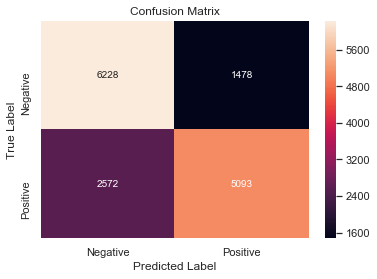

In [35]:
confusion_matrix_c(y_test, y_pred_lr)

In [36]:
#Score of Prediction
lr_score_train = lr.score(X_train,y_train)
print("Train Prediction Score",lr_score_train*100)
lr_score_test = accuracy_score(y_test,y_pred_lr)
print("Test Prediction Score",lr_score_test*100)

Train Prediction Score 73.40713269943954
Test Prediction Score 73.65168173833843


In [37]:
print('AUC: ', roc_auc_score(y_test, y_pred_lr))

AUC:  0.7363250973606186


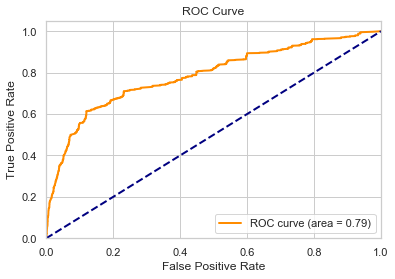

In [38]:
y_predict_probabilities = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

## K-Nearest Neighbour¶

In [39]:
# Fitting KNN to the Training set
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [40]:
# Predicting the Test set results
y_pred_knn= lr.predict(X_test)

In [41]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      7706
           1       0.78      0.66      0.72      7665

   micro avg       0.74      0.74      0.74     15371
   macro avg       0.74      0.74      0.74     15371
weighted avg       0.74      0.74      0.74     15371



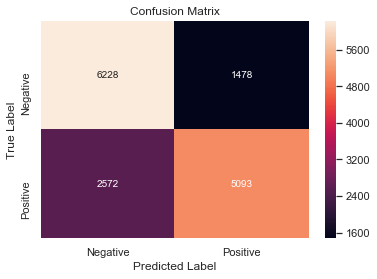

In [42]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_knn)

In [43]:
#Score of Prediction
knn_score_train = knn.score(X_train,y_train)
print("Train Prediction Score",knn_score_train*100)
knn_score_test = accuracy_score(y_test,y_pred_knn)
print("Test Prediction Score",knn_score_test*100)

Train Prediction Score 92.5550009759362
Test Prediction Score 73.65168173833843


In [44]:
print('AUC: ', roc_auc_score(y_test, y_pred_knn))

AUC:  0.7363250973606186


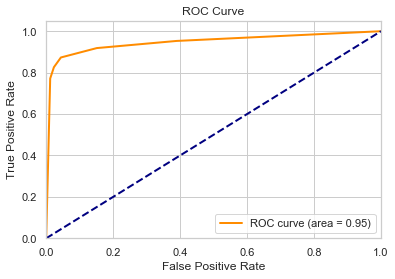

In [45]:
y_predict_probabilities = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

## Support Vector Machine

In [46]:
# Fitting SVM to the Training set
svc = SGDClassifier(loss = 'hinge',random_state = 42)
svc_clf = CalibratedClassifierCV(svc, cv=5, method='sigmoid')
svc_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [47]:
# Predicting the Test set results
y_pred_svc= svc_clf.predict(X_test)

In [48]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.70      0.87      0.77      7706
           1       0.82      0.62      0.71      7665

   micro avg       0.75      0.75      0.75     15371
   macro avg       0.76      0.74      0.74     15371
weighted avg       0.76      0.75      0.74     15371



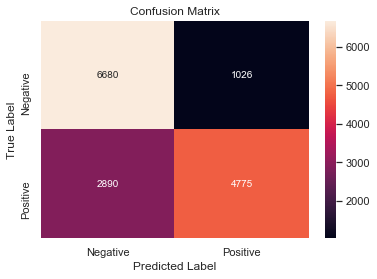

In [49]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_svc)

In [50]:
#Score of Prediction
svc_score_train = svc_clf.score(X_train,y_train)
print("Train Prediction Score",svc_score_train*100)
svc_score_test = accuracy_score(y_test,y_pred_svc)
print("Test Prediction Score",svc_score_test*100)

Train Prediction Score 74.35518500961994
Test Prediction Score 74.52345325613167


In [51]:
print('AUC: ', roc_auc_score(y_test, y_pred_svc))

AUC:  0.744909253961087


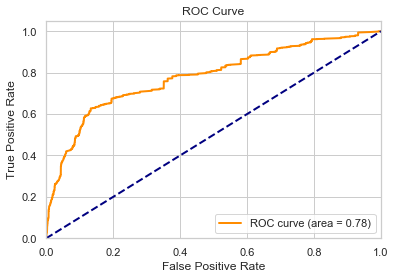

In [52]:
y_predict_probabilities = svc_clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

## LGBM 

In [53]:
# Fitting LGBM to the Training set
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

lgbmc = lgb.LGBMClassifier(random_state=42)
lgbmc.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
# Predicting the Test set results
y_pred_lgbmc= lgbmc.predict(X_test)

In [55]:
print(classification_report(y_test,y_pred_lgbmc))

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      7706
         1.0       0.94      0.89      0.92      7665

   micro avg       0.92      0.92      0.92     15371
   macro avg       0.92      0.92      0.92     15371
weighted avg       0.92      0.92      0.92     15371



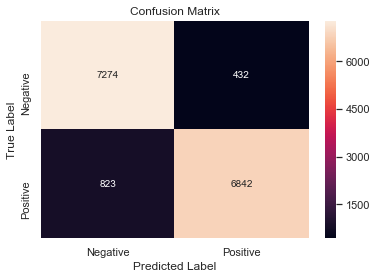

In [56]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_lgbmc)

In [57]:
#Score of Prediction
lgbmc_score_train = lgbmc.score(X_train,y_train)
print("Train Prediction Score",lgbmc_score_train*100)
lgbmc_score_test = accuracy_score(y_test,y_pred_lgbmc)
print("Test Prediction Score",lgbmc_score_test*100)

Train Prediction Score 92.20924072163511
Test Prediction Score 91.83527421768265


In [58]:
print('AUC: ', roc_auc_score(y_test, y_pred_lgbmc))

AUC:  0.9182843097668408


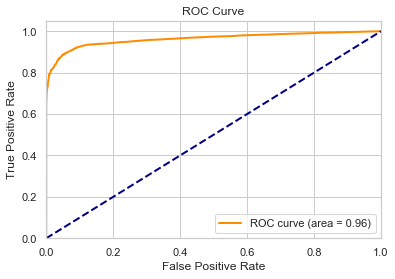

In [59]:
y_predict_probabilities = lgbmc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)